Tutorial from: https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/ 

Aim: Use ML to predict the grade of diabetic retinopathy from a fundus image. Therefore a multi-class image classification problem. Solved by using a pre-trained model InceptionResNetV2, and customizing it.

InceptionResNetV2: is a convolutional neural network that is 164 layers deep, trained on millions of images from the ImageNet database, and can classify images into more than 1000 categories such as flowers, animals, etc. The input size of the images is 299-by-299.

Necessities for transfer learning: Low-level features from model A (task A) should be helpful for learning model B (task B).

In [1]:
# Import

import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


2023-09-15 12:20:17.397966: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-15 12:20:36.022299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 12:21:07.751943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set up

data_path = './data/UoA-DR/' 
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, "test") 
label_path = os.path.join(data_path, 'UoA-DR-labels.csv')

labels = pd.read_csv(label_path)

x_name = "image number"
y_name = "class"

possible_labels = sorted(labels[y_name].unique())
print(possible_labels)

labels.head()

# print("Train Path:", train_path)
# print("Validation Path:", test_path)



['healthy', 'npdr', 'pdr']


,image number,class,healthy,npdr,pdr
0,1,npdr,0,1,0
1,2,npdr,0,1,0
2,3,npdr,0,1,0
3,4,npdr,0,1,0
4,5,npdr,0,1,0


In [3]:
# Custom function to convert image number to file path
extension = ".jpg"
def to_file_path(id):
    return os.path.join(labels[labels[x_name] == id][y_name].values[0], id + extension)

# Custom functions to convert image number with JPG extension
def to_jpg(id):
    return str(id) + ".jpg"

# Apply the to_file_path function if the folder is sorted by class, otherwise apply the to_jpg function
if len(os.listdir(os.path.join(train_path))) > 1 and len(os.listdir(os.path.join(test_path))) > 1:
    conversion = to_file_path
elif len(os.listdir(os.path.join(train_path))) == 0 and len(os.listdir(os.path.join(test_path))) == 0:
    conversion = to_jpg
else:
    print("Error with training and testing file sizes")
    
labels[x_name] = labels[x_name].astype(str)
labels[x_name] = labels[x_name].apply(conversion)

labels.head()


,image number,class,healthy,npdr,pdr
0,npdr/1.jpg,npdr,0,1,0
1,npdr/2.jpg,npdr,0,1,0
2,npdr/3.jpg,npdr,0,1,0
3,npdr/4.jpg,npdr,0,1,0
4,npdr/5.jpg,npdr,0,1,0


In [4]:
# Data agumentation and pre-processing

rescale_factor = 1./255.
has_horizontal_flip = True
validation_split = 0.2 # training: 80% data, validation: 20% data
batch_size = 12
has_shuffle = True
seed = 49
image_size = (331, 331) # image height , image width

gen = ImageDataGenerator( # TODO add rotation_range=30 or zoom_range=0.4??
				rescale= rescale_factor,
				horizontal_flip = has_horizontal_flip,
				validation_split= validation_split 
				)

train_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = train_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="training",
	color_mode="rgb",
	target_size = image_size, 
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)


validation_generator = gen.flow_from_dataframe(
	labels, # dataframe
	directory = test_path, # images data path / folder in which images are there
	x_col = x_name,
	y_col = y_name,
	subset="validation",
	color_mode="rgb",
	target_size = image_size,
	class_mode="categorical",
	batch_size=batch_size,
	shuffle=has_shuffle,
	seed=seed,
)

x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

Found 135 validated image filenames belonging to 3 classes.
Found 6 validated image filenames belonging to 3 classes.


(12, 331, 331, 3)

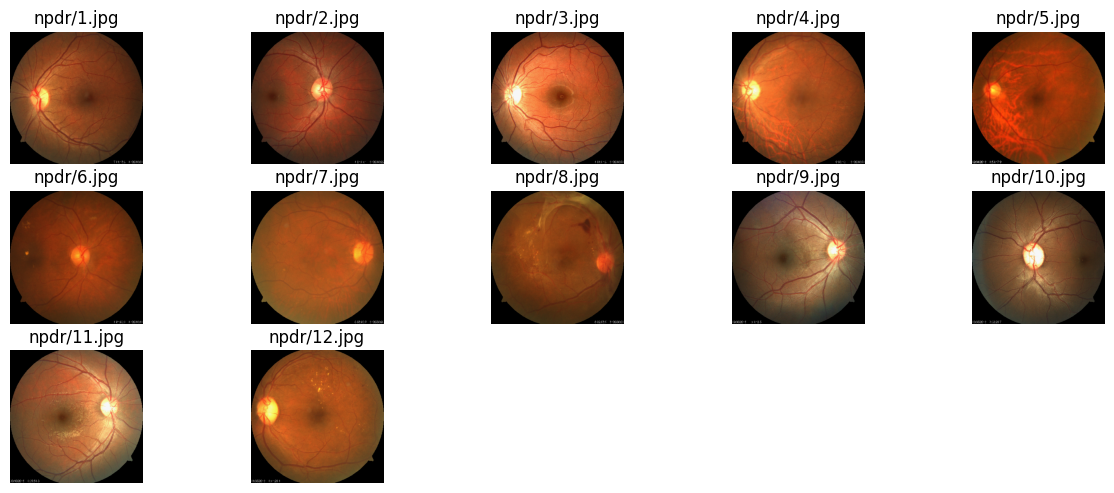

In [5]:
# Plot images

a = train_generator.class_indices
class_names = list(a.keys()) # storing class names in a list


# def plot_images(img, labels):
# 	plt.figure(figsize=[15, 10])
# 	for i in range(25):
# 		plt.subplot(5, 5, i+1)
# 		plt.imshow(img[i])
# 		plt.title(class_names[np.argmax(labels[i])])
# 		plt.axis('off')

# plot_images(x,y)


def plot_images_with_numbers(img, labels, image_numbers):
    plt.figure(figsize=[15, 10])
    for i in range(batch_size):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(f"{image_numbers[i]}")
        plt.axis('off')

plot_images_with_numbers(x, y, labels[x_name][:batch_size])  # Plot the first 25 images and their numbers


In [6]:
# Define a function to create and compile models with different architectures
def create_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        BatchNormalization(renorm=True), #normalize the activations
        GlobalAveragePooling2D(), # reduce spatial dimensions.
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.5), # prevent overfitting.
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
import tensorflow as tf

print('TensorFlow version:',tf.__version__)
physical_devices = tf.config.list_physical_devices()
for dev in physical_devices:
    print(dev)

sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print("CUDA version:",cuda_version)
cudnn_version = sys_details["cudnn_version"]
print("CUDNN version:",cudnn_version)

TensorFlow version: 2.13.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
CUDA version: 11.8
CUDNN version: 8


In [7]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
# Check if TensorFlow is using the GPU
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True


2023-09-15 12:22:28.585402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 12:22:28.637672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-15 12:22:28.637818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
import tensorflow as tf

# List available physical GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU device
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Optional: Set a specific GPU memory limit (in MB)
        # tf.config.experimental.set_virtual_device_configuration(
        #     gpus[0],
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Adjust the memory limit as needed

        print("GPU memory growth and limit set successfully.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU devices found.")


Physical devices cannot be modified after being initialized


In [8]:
# Experiment with different base models
base_models = {
    # "EfficientNetB3": EfficientNetB3(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "ResNet50": ResNet50(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "VGG16": VGG16(input_shape=(331, 331, 3), include_top=False, weights='imagenet')
}

results = {}

for model_name, base_model in base_models.items():
    model = create_model(base_model, (331, 331, 3), num_classes=3)
    
    # Define early stopping callback to monitor the 'accuracy' metric and prevent overfitting.
    # Training is stopped early if the accuracy doesn't improve after a certain number of epochs (controlled by patience)
    early = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True, monitor='accuracy')
    
    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=25,
        callbacks=[early]
    )
    
    # Save or analyze the model and its performance
    # Store the results in the dictionary
    results[model_name] = {
        "model": model,
        "history": history.history
    }

# Now you can access the results for each model and analyze their performance
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print("Validation Accuracy:", max(result["history"]["val_accuracy"]))# Experiment with different base models
base_models = {
    "EfficientNetB3": EfficientNetB3(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "ResNet50": ResNet50(input_shape=(331, 331, 3), include_top=False, weights='imagenet'),
    "VGG16": VGG16(input_shape=(331, 331, 3), include_top=False, weights='imagenet')
}

results = {}

for model_name, base_model in base_models.items():
    model = create_model(base_model, (331, 331, 3), num_classes=3)
    
    # Define early stopping callback to monitor the 'accuracy' metric and prevent overfitting.
    # Training is stopped early if the accuracy doesn't improve after a certain number of epochs (controlled by patience)
    early = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True, monitor='accuracy')
    
    # Fit the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        epochs=25,
        callbacks=[early]
    )
    
    # Save or analyze the model and its performance
    # Store the results in the dictionary
    results[model_name] = {
        "model": model,
        "history": history.history
    }


2023-09-14 11:50:35.852520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 11:50:35.852674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 11:50:35.852732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/25


2023-09-14 11:51:02.980902: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 80.73MiB (rounded to 84652032)requested by op sequential/resnet50/conv1_conv/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-09-14 11:51:02.980952: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-09-14 11:51:02.980960: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 104, Chunks in use: 103. 26.0KiB allocated for chunks. 25.8KiB in use in bin. 9.8KiB client-requested in use in bin.
2023-09-14 11:51:02.980967: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 45, Chunks in use: 45. 22.5KiB allocated for chunks. 22.5KiB in use in bin. 22.5KiB client-requested in use in bin.
2023-09-14 11:51:02.980

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/resnet50/conv1_conv/Conv2D' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/csse/users/yyu69/miniconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/csse/users/yyu69/miniconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/csse/users/yyu69/miniconda3/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_73291/3370672164.py", line 18, in <module>
      history = model.fit(
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/csse/users/yyu69/Desktop/SENG402/trying image classification tuts/Deep-Learning-Image-Classifier/image-classification-venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/resnet50/conv1_conv/Conv2D'
OOM when allocating tensor with shape[12,166,166,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/resnet50/conv1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11495]

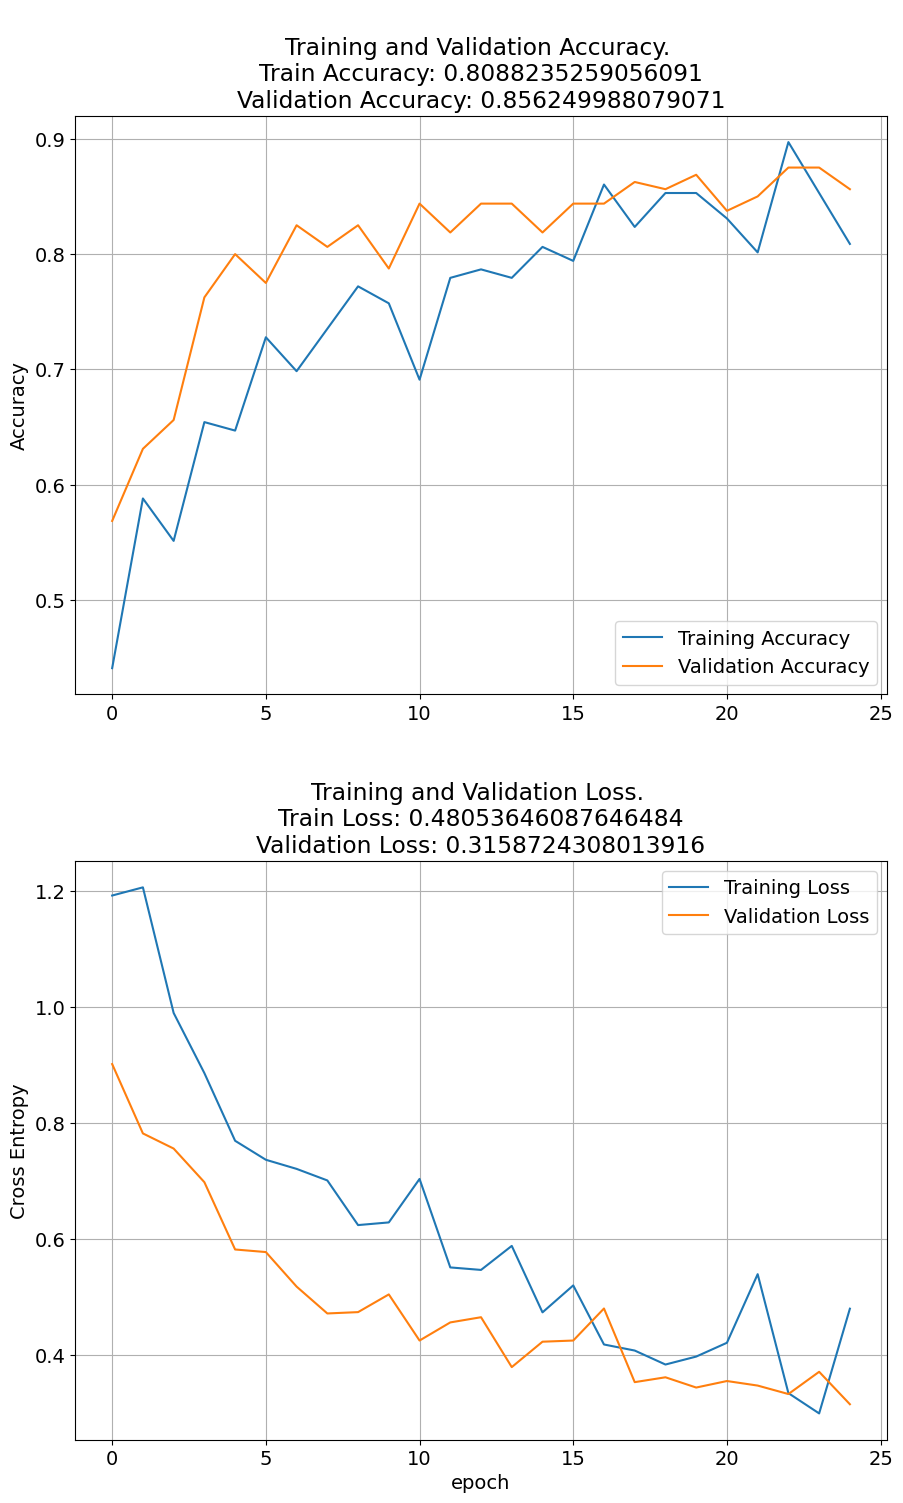

In [10]:
# Visualize model

# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] # or maybe val_acc
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')


# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [11]:
# Evaluate model

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


6/6 [==============================] - 6s 926ms/step - loss: 0.3063 - accuracy: 0.8631
[0.3062507212162018, 0.863095223903656]
Accuracy: 86.3095%
Loss:  0.3062507212162018


1/1 [==============================] - 0s 19ms/step
Prediction: [[0.45068353 0.5243837  0.02493278]]
Labels: ['healthy', 'npdr', 'pdr']
Predicted class: npdr


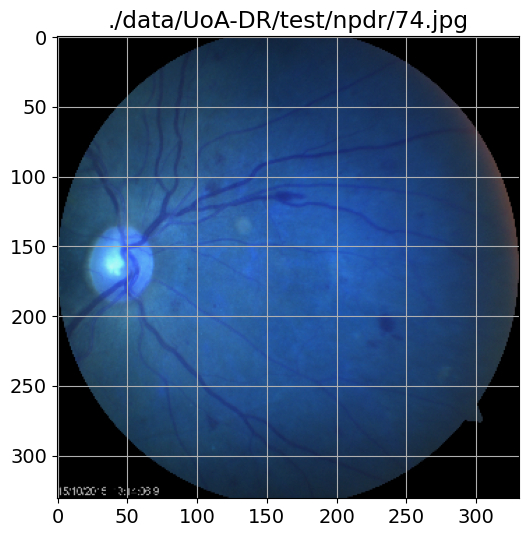

In [111]:
# Testing

test_img_path = os.path.join(test_path, "npdr/74.jpg")
# test_img_path="PDR.jpg"
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255
 
plt.figure(figsize=(6,6))
plt.title(test_img_path)
plt.imshow(resized_img[0])


img = tf.keras.preprocessing.image.load_img(test_img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
img = tf.reshape(img, (-1, 331, 331, 3))
prediction = model.predict(img/255)

print("Prediction:", prediction)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(prediction)

print("Labels:", possible_labels) # TODO check if this is matched properly
print("Predicted class:", possible_labels[predicted_class_index])



In [112]:
# Save model

model.save("models/Model.h5")
